### Install and load all neded stuff

In [1]:
!pip install nuscenes-devkit

     |████████████████████████████████| 286kB 2.9MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=e13f6fbaa2f6b5c3e88e7c45ee66ae0163cbe8494ea55a82a9fa681a6803efb0
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = './drive/MyDrive/SDC_nuScenes_DS/'

nusc = NuScenes('v1.0-mini', dataroot=DATAROOT)
helper = PredictHelper(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 4.928 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


## Trajectory prediction for objects

In [5]:
# current_ann = nusc.get('sample_annotation', 'e7a2133afb9c4c9b834225cc959d475a')
# current_ann

In [6]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

# Scene 4
#ROW_ID = 250

# Minival ROW_ID = 2 Crash
# Minival ROW_ID = 15 Traffic lights crash

# Mini truck with big truck
# target_instance_token, start_prediction_sample_token = '6ae762f1bc254d00bfb5ae9d66ffe376', '7315022fc89147a6afc7f978601f8f38'

# Movable object
# target_instance_token, start_prediction_sample_token = '340ccb3c0dcb492eaa032f0e4e3017bb', '7315022fc89147a6afc7f978601f8f38'

# target_instance_token, start_prediction_sample_token = '085fb7c411914888907f7198e998a951', 'ca9a282c9e77460f8360f564131a8af5'

ROW_ID = 27

mini_train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)
mini_val = get_prediction_challenge_split("mini_val", dataroot=DATAROOT)

print(f"Train len: {len(mini_train)}; \nVal len: {len(mini_val)}")

target_instance_token, start_prediction_sample_token = mini_val[ROW_ID].split("_")

Train len: 742; 
Val len: 61


In [7]:
# Uncommit that cod if need to find anothers instances on this sample

# start_prediction_sample = nusc.get('sample', 'ca9a282c9e77460f8360f564131a8af5')

# my_annotation_metadata =  nusc.get('sample_annotation', start_prediction_sample['anns'][7])
# my_annotation_metadata

In [9]:
# Get sample info

start_sample = nusc.get('sample', start_prediction_sample_token)

start_prediction_annotation = helper.get_sample_annotation(target_instance_token, start_prediction_sample_token)
start_prediction_annotation_token = start_prediction_annotation['token']

start_prediction_annotation

{'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'category_name': 'vehicle.car',
 'instance_token': 'f3995943006145ca8a7bc375527f0aba',
 'next': '7d3d36af34b14848adb31e0efc2687e1',
 'num_lidar_pts': 0,
 'num_radar_pts': 1,
 'prev': 'bf9391180902443db3e8b0f7a9e479ae',
 'rotation': [0.3579985896649038, 0.0, 0.0, 0.9337221266511466],
 'sample_token': 'c5f58c19249d4137ae063b0e9ecd8b8e',
 'size': [1.803, 4.495, 1.56],
 'token': 'da678cc6244b46018ab72a7b4301d460',
 'translation': [654.69, 1609.754, -0.24],
 'visibility_token': '4'}

In [10]:
# Get instance info

target_instance = nusc.get('instance', target_instance_token)
target_instance

{'category_token': 'fd69059b62a3469fbaef25340c0eab7f',
 'first_annotation_token': 'a977de149680431ca2c0c462132db5e2',
 'last_annotation_token': '105ff35e670f41968158ddec8e48d1c7',
 'nbr_annotations': 16,
 'token': 'f3995943006145ca8a7bc375527f0aba'}

Render first and last annotation of that instance:

First annotated sample of this instance:
Last annotated sample of this instance


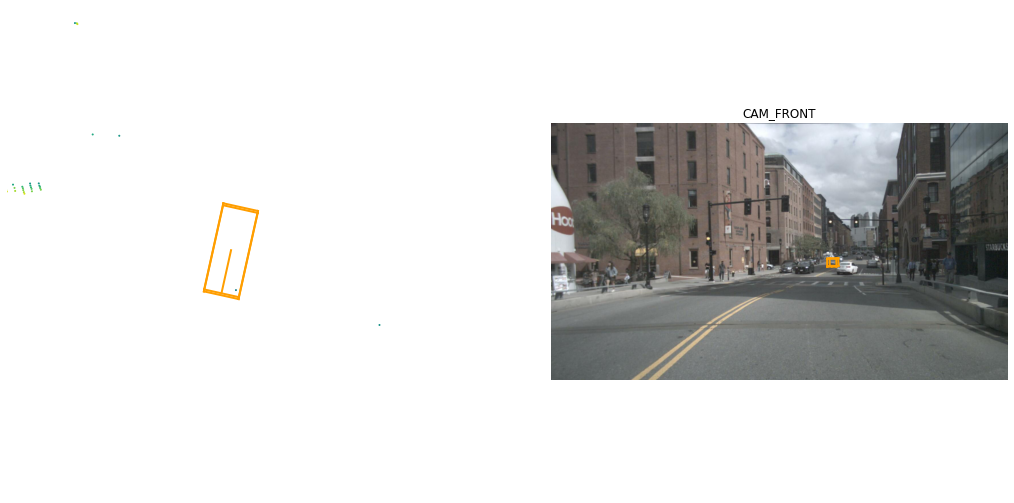

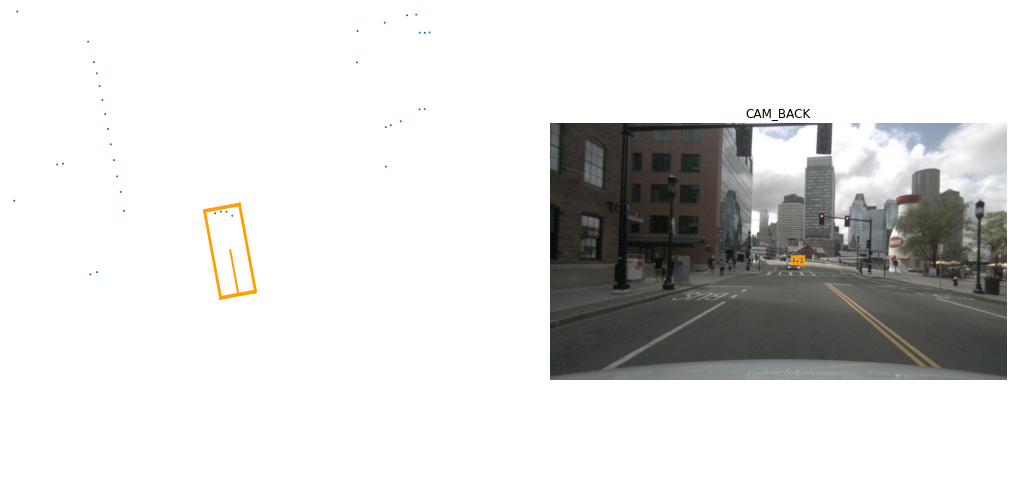

In [11]:
print("First annotated sample of this instance:")
nusc.render_annotation(target_instance['first_annotation_token'])

print("Last annotated sample of this instance")
nusc.render_annotation(target_instance['last_annotation_token'])

In [12]:
# Params in seconds
history_length = 2
prediction_length = 6

In [14]:
# Get last prediction snapshot's annotation
all_annotations = helper.get_future_for_agent(target_instance_token, start_prediction_sample_token, seconds=prediction_length, in_agent_frame=False, just_xy=False)
last_annotation = all_annotations[len(all_annotations) - 1]

finish_prediction_sample_token = last_annotation['sample_token']
finish_prediction_annotation_token = last_annotation['token']

# Get start history snapshot's annotation
all_annotations = helper.get_past_for_agent(target_instance_token, start_prediction_sample_token, seconds=history_length, in_agent_frame=False, just_xy=False)
last_annotation = all_annotations[len(all_annotations) - 1]

start_history_sample_token = last_annotation['sample_token']
start_history_annotation_token = last_annotation['token']

In [15]:
def RenderAnnotationsInRange(start_annotate_token, finish_annotate_token):
  current_token = start_annotate_token

  while current_token != finish_annotate_token:
    current_ann = nusc.get('sample_annotation', current_token)
    
    nusc.render_annotation(current_token)

    next_token = current_ann['next']
    current_token = next_token

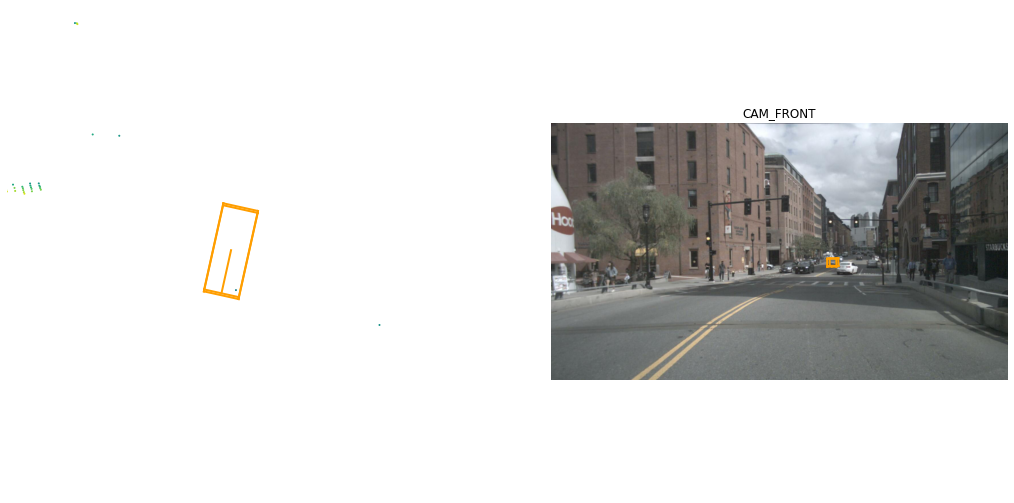

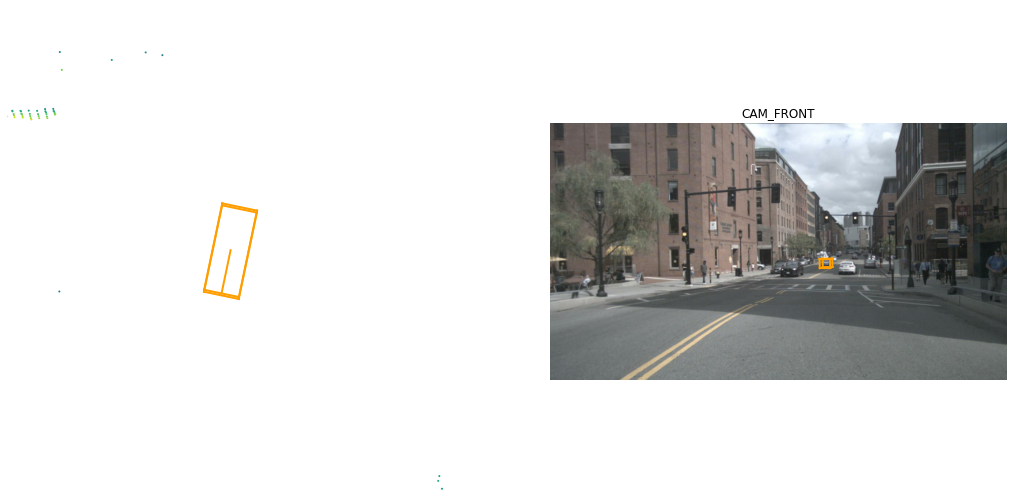

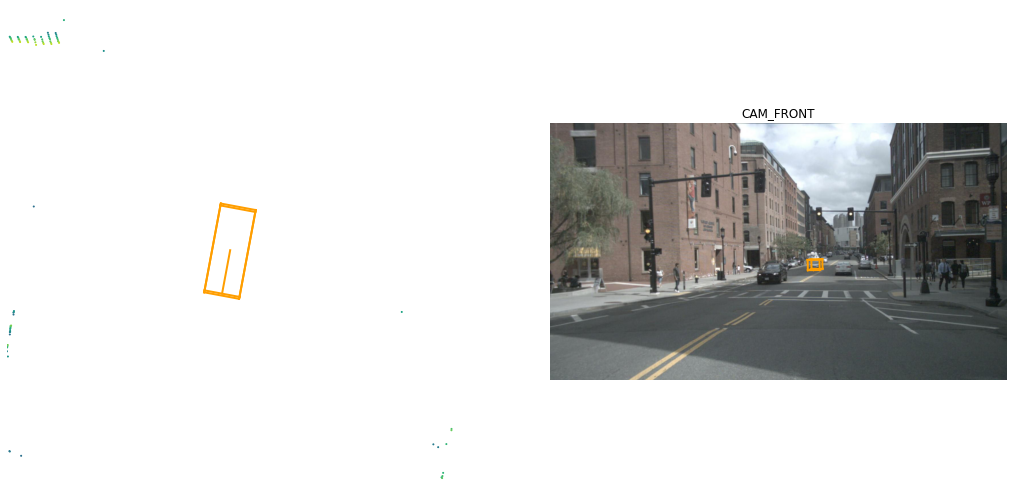

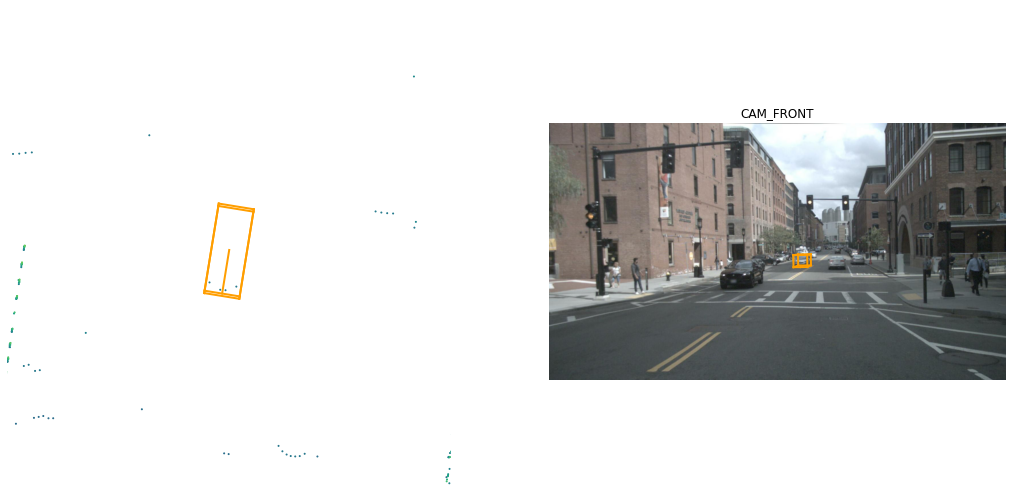

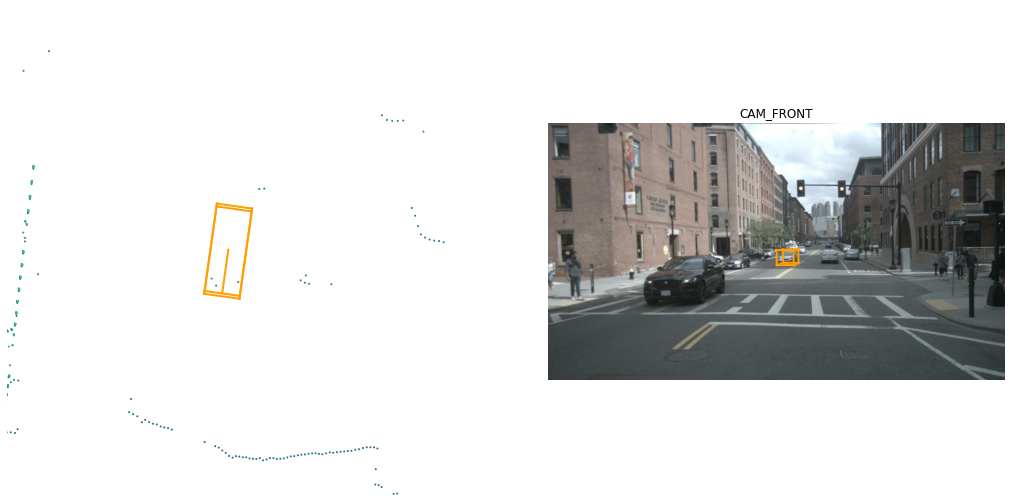

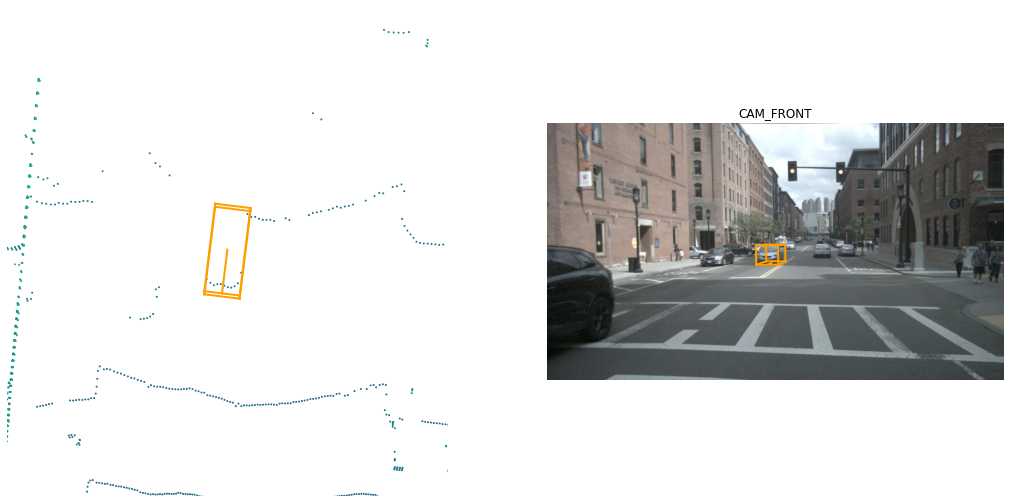

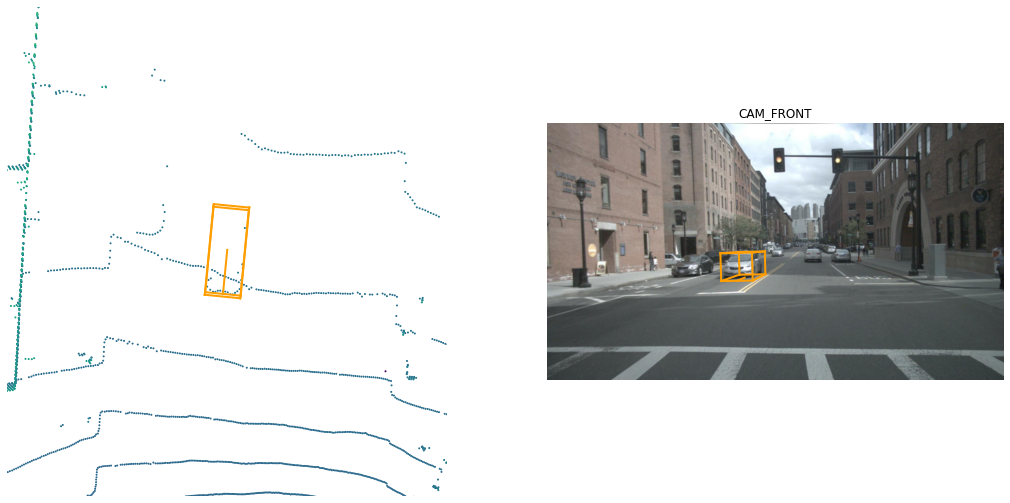

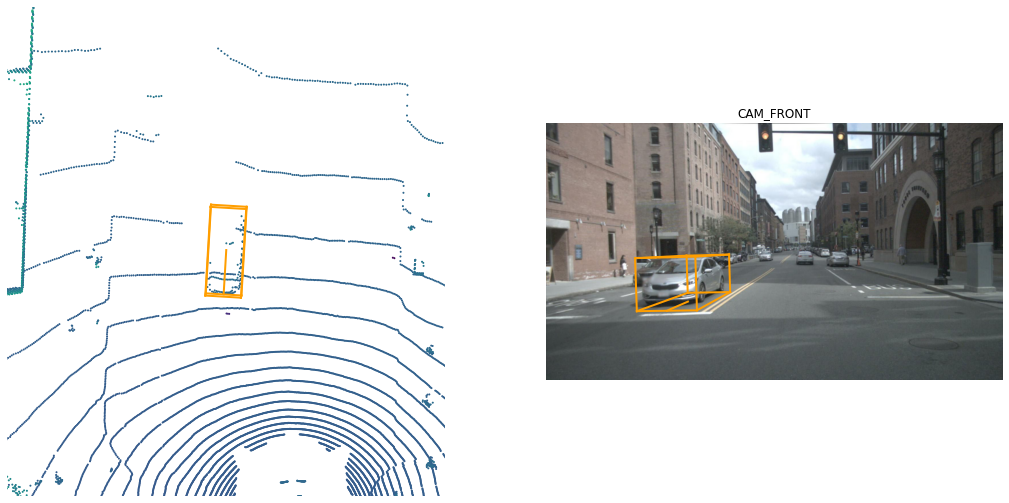

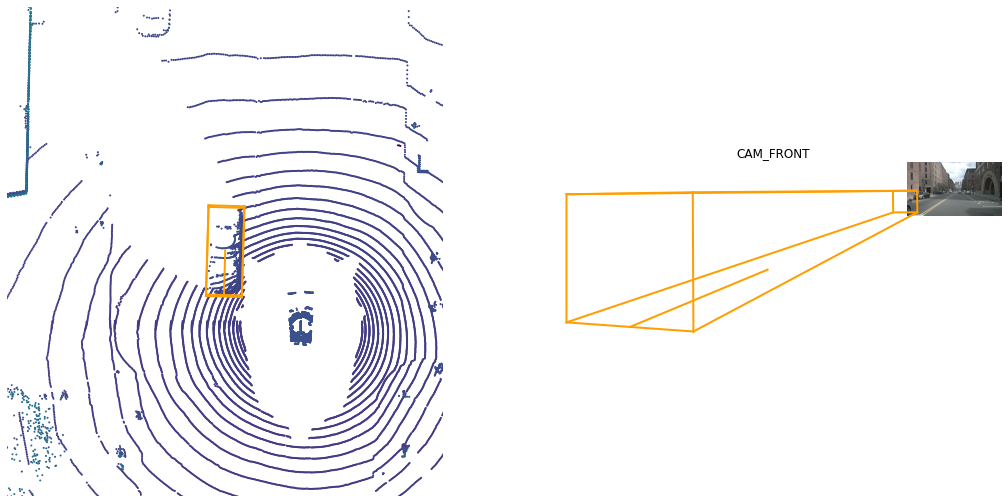

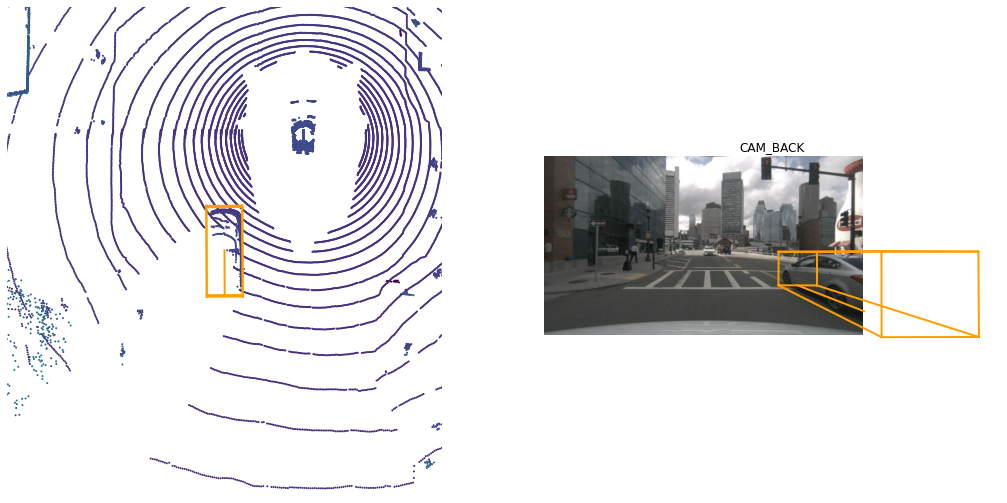

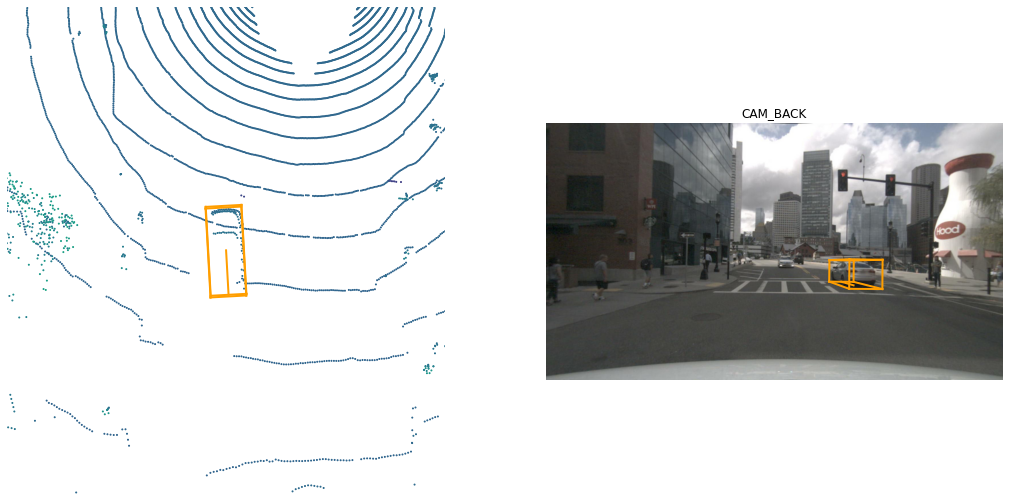

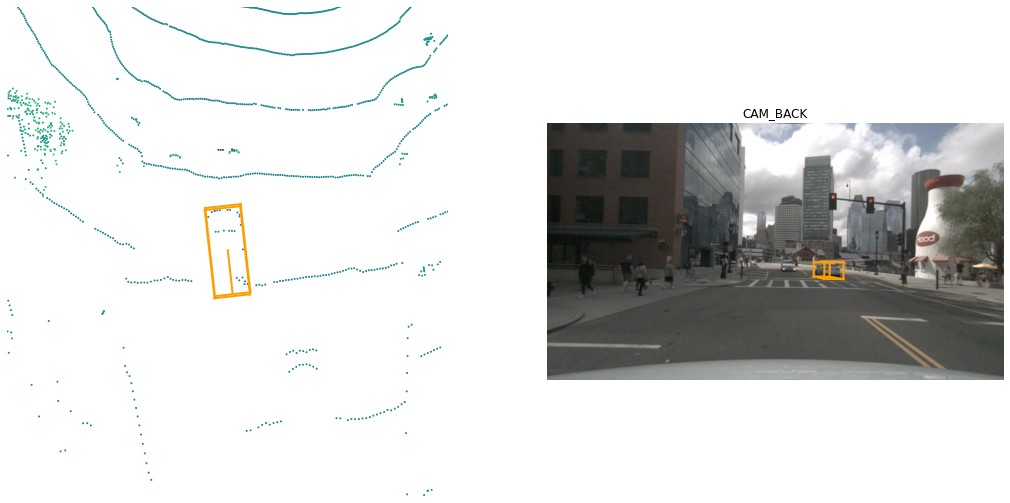

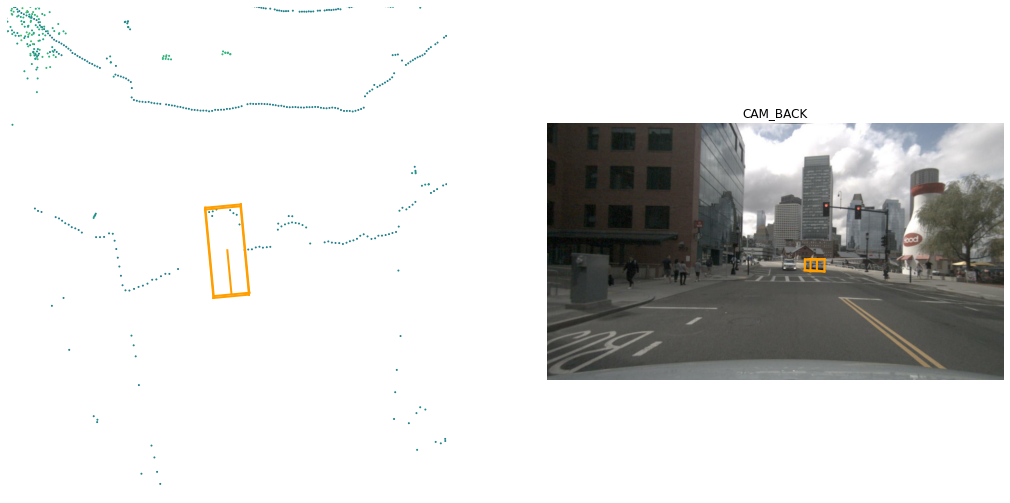

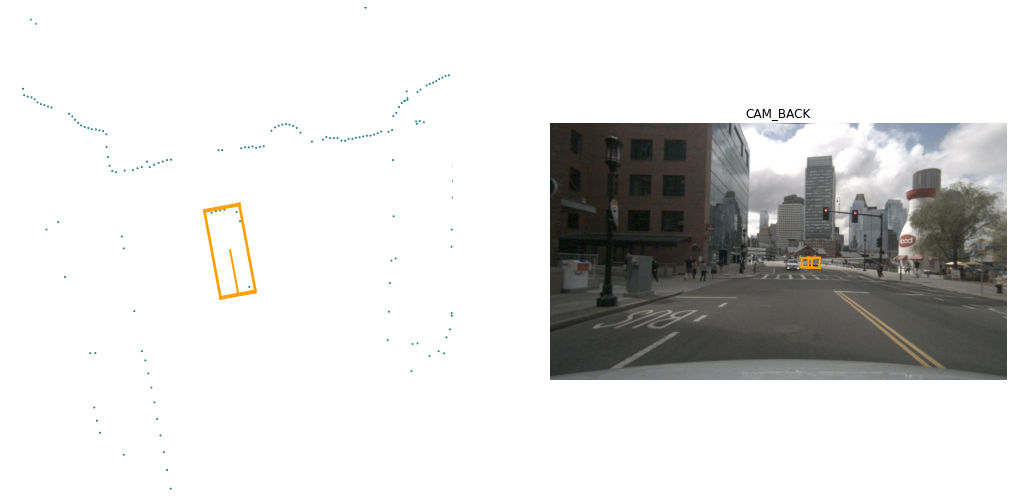

In [16]:
# Look at that's agent moving which captured by camera
RenderAnnotationsInRange(start_history_annotation_token, finish_prediction_annotation_token)

Generate input representation

Vel: 8.162590134491664 
Accel: 0.021510827318528176 
Heading: -0.011638597339400208 



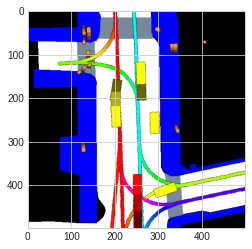

In [22]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

static_layer_rasterizer = StaticLayerRasterizer(helper) #, layer_names=['traffic_light', 'road_segment'])
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

instance_token_img, sample_token_img = target_instance_token, start_prediction_sample_token
velocity = helper.get_velocity_for_agent(instance_token_img, sample_token_img)
acceleration = helper.get_acceleration_for_agent(instance_token_img, sample_token_img)
heading = helper.get_heading_change_rate_for_agent(instance_token_img, sample_token_img)

print(f"Vel: {velocity} \nAccel: {acceleration} \nHeading: {heading} \n")

anns = [ann for ann in nusc.sample_annotation if ann['instance_token'] == instance_token_img]

img = mtp_input_representation.make_input_representation(instance_token_img, sample_token_img)
plt.imshow(img)

### Plot path as Input representation map's gif

In [23]:
# Importing Image module from PIL package 
from PIL import Image 
import PIL 
from IPython.display import Image
import IPython.display
import imageio
import os

GIF_PATH = 'gifs/IR.gif'

def PlotInputRepresentationMap(start_annotate_token, finish_annotate_token):
  current_token = start_annotate_token
  i = 1

  images_to_gif = []

  while current_token != finish_annotate_token:
      current_ann = nusc.get('sample_annotation', current_token)
      img = mtp_input_representation.make_input_representation(instance_token_img, current_ann['sample_token'])
      
      images_to_gif.append(img)
      
      next_token = current_ann['next']
      current_token = next_token
      i += 1

  imageio.mimsave(DATAROOT + GIF_PATH, images_to_gif)
  print(f"Number of annotations: {i}")
  #display.Image(open(DATAROOT + GIF_PATH,'rb').read(), width=250, height=250)

  with open(DATAROOT + GIF_PATH,'rb') as f:
      display(Image(data=f.read(), format='png', width=250, height=250))

Full path
Number of annotations: 16


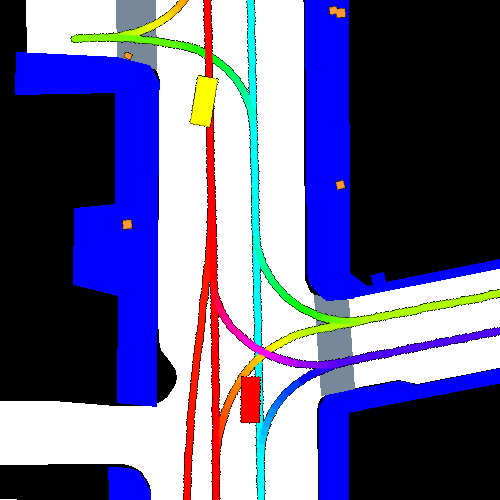

In [24]:
first_ann_token = target_instance['first_annotation_token']
last_ann_token = target_instance['last_annotation_token']

print("Full path")
PlotInputRepresentationMap(first_ann_token, last_ann_token)

History + prediction part
Number of annotations: 15


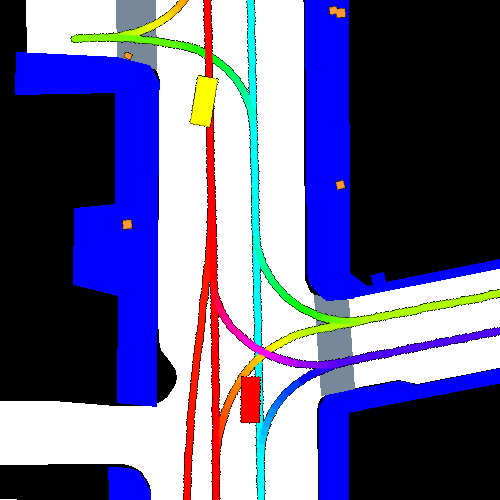

In [25]:
print("History + prediction part")
PlotInputRepresentationMap(start_history_annotation_token, finish_prediction_annotation_token)

### Look at coordinates

In [26]:
history_path = helper.get_past_for_agent(instance_token_img, start_prediction_sample_token, seconds=history_length, in_agent_frame=False)
future_path = helper.get_future_for_agent(instance_token_img, start_prediction_sample_token, seconds=prediction_length, in_agent_frame=False)

print(f"History path: \n{history_path} \nlen: {len(history_path)}")
print()
print(f"Future path: \n{future_path} \nlen: {len(future_path)}")

History path: 
[[ 657.771 1607.079]
 [ 660.851 1604.404]] 
len: 2

Future path: 
[[ 651.61  1612.428]
 [ 648.307 1615.333]
 [ 645.004 1618.239]
 [ 641.7   1621.144]
 [ 637.96  1624.547]
 [ 634.22  1627.951]
 [ 630.365 1631.31 ]
 [ 626.655 1634.338]
 [ 622.783 1637.156]
 [ 618.8   1639.926]
 [ 615.607 1642.064]
 [ 610.999 1644.73 ]] 
len: 12


In [27]:
local_history_path = helper.get_past_for_agent(instance_token_img, start_prediction_sample_token, seconds=history_length, in_agent_frame=True)
local_future_path = helper.get_future_for_agent(instance_token_img, start_prediction_sample_token, seconds=prediction_length, in_agent_frame=True)

print(f"History local path: \n{local_history_path} \nlen: {len(local_history_path)}")
print()
print(f"Future local path: \n{local_future_path} \nlen: {len(local_future_path)}")

History local path: 
[[ 0.07045116 -4.0796106 ]
 [ 0.14023378 -8.15847752]] 
len: 2

Future local path: 
[[-0.07052629  4.07819838]
 [-0.11834884  8.47666937]
 [-0.16542772 12.87580889]
 [-0.21391881 17.27502355]
 [-0.18354473 22.3314142 ]
 [-0.15242698 27.3884734 ]
 [-0.23165693 32.50097069]
 [-0.46010434 37.28434772]
 [-0.95302716 42.04780603]
 [-1.55585454 46.86172213]
 [-2.1005354  50.66561694]
 [-3.19854388 55.87480089]] 
len: 12


Global path:


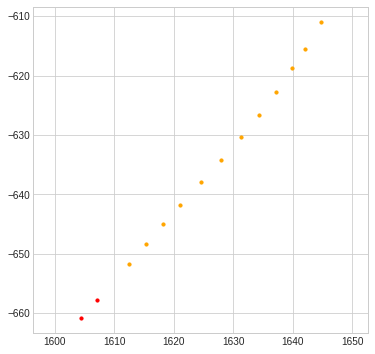

Local path:


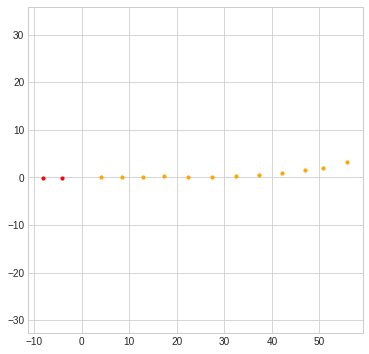

In [28]:
def PlotPathWithPrediction(history, future, predict = [], amount = 999):
  plt.figure(figsize=(6, 6))

  plt.scatter(history[:, 1], -history[:, 0], c='r', s=10)
  plt.scatter(future[:, 1], -future[:, 0], c='orange', s=10)

  if (len(predict) > 0):
    plt.scatter(predict[:, 1], -predict[:, 0], c='g', s=10)

  # Keep aspect ratio of axis
  plt.axis('equal')
  plt.show()

print("Global path:")
PlotPathWithPrediction(history_path, future_path)

print("Local path:")
PlotPathWithPrediction(local_history_path, local_future_path)

### Predictions

In [29]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet
import torch

backbone = ResNetBackbone('resnet50')
mtp = MTP(backbone, num_modes=2)

# Note that the value of num_modes depends on the size of the lattice used for CoverNet.
covernet = CoverNet(backbone, num_modes=64)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [30]:
agent_state_vector = torch.Tensor([[helper.get_velocity_for_agent(instance_token_img, sample_token_img),
                                    helper.get_acceleration_for_agent(instance_token_img, sample_token_img),
                                    helper.get_heading_change_rate_for_agent(instance_token_img, sample_token_img)]])

In [31]:
image_tensor = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0)

### Predictions by MTP

In [32]:
# Output has 50 entries.
# The first 24 are x,y coordinates (in the agent frame) over the next 6 seconds at 2 Hz for the first mode.
# The second 24 are the x,y coordinates for the second mode.
# The last 2 are the logits of the mode probabilities

predict = mtp(image_tensor, agent_state_vector) #[0].detach().numpy()

print(f"Shape: [{predict.size()}] \n")
predict = predict[0].detach().numpy()

mode_one_predict = predict[0:24]
mode_two_predict = predict[24:48]

print(f"Mode one: \n{mode_one_predict}\n")

print(f"Mode two: \n{mode_two_predict}\n")

print(f"Logits: {predict[48], predict[49]} \n")

predict_m1 = mode_one_predict.reshape(12, 2)
print(f"Mode one reshape: \n{predict_m1}\n")

predict_m2 = mode_two_predict.reshape(12, 2)
print(f"Mode two reshape: \n{predict_m2}\n")

Shape: [torch.Size([1, 50])] 

Mode one: 
[ 0.28114122  0.06291972 -0.20059273  0.36873823 -0.29417697  0.0573879
 -0.35182753  0.7732364   0.30813897 -0.06055438 -0.03816904 -0.41068566
  0.08566817 -0.21406512  1.1204648   0.12327566 -0.04657497  0.42086387
  0.11482451 -0.21375398  0.336635   -0.21605954  0.17319734 -0.46435493]

Mode two: 
[ 0.4337019  -0.6999697   0.04607865 -0.11873375  0.53983796 -0.19441162
  0.2025229  -0.2007726   0.15393668 -0.74315757 -0.4623948  -0.03820277
 -0.223538    0.36482123 -0.29929113  0.0894803  -0.56685567  0.69199836
 -0.31158248 -0.28603637 -0.35772622 -0.41761932 -0.09513637  0.13983604]

Logits: (0.22213948, 0.51872414) 

Mode one reshape: 
[[ 0.28114122  0.06291972]
 [-0.20059273  0.36873823]
 [-0.29417697  0.0573879 ]
 [-0.35182753  0.7732364 ]
 [ 0.30813897 -0.06055438]
 [-0.03816904 -0.41068566]
 [ 0.08566817 -0.21406512]
 [ 1.1204648   0.12327566]
 [-0.04657497  0.42086387]
 [ 0.11482451 -0.21375398]
 [ 0.336635   -0.21605954]
 [ 0.1731

[[ 0.28114122  0.06291972]
 [-0.20059273  0.36873823]
 [-0.29417697  0.0573879 ]
 [-0.35182753  0.7732364 ]
 [ 0.30813897 -0.06055438]
 [-0.03816904 -0.41068566]
 [ 0.08566817 -0.21406512]
 [ 1.1204648   0.12327566]
 [-0.04657497  0.42086387]
 [ 0.11482451 -0.21375398]
 [ 0.336635   -0.21605954]
 [ 0.17319734 -0.46435493]]

[0.080548495, 0.43165797]
[-0.21362847, 0.48904586]
[-0.56545603, 1.2622823]
[-0.25731707, 1.2017279]
[-0.2954861, 0.7910422]
[-0.20981792, 0.5769771]
[0.9106469, 0.7002527]
[0.86407197, 1.1211166]
[0.9788965, 0.90736264]
[1.3155315, 0.69130313]
[1.4887289, 0.2269482]


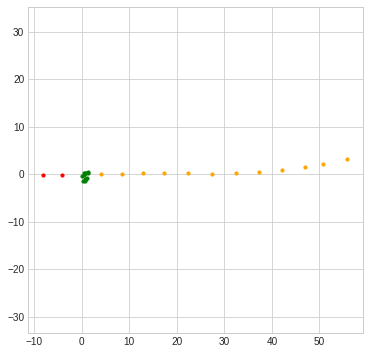

In [33]:
predict = predict_m1
print(predict)
print()

new_predict = [predict[0]]

for i in range(1, len(predict)):
  new_point = [new_predict[i - 1][0] + predict[i][0], new_predict[i - 1][1] + predict[i][1]]
  new_predict.append(new_point)
  print(new_point)

PlotPathWithPrediction(local_history_path, local_future_path, np.asarray(new_predict))

### Predictions by CoverNet

Lets see on all generated trajectories from which we will make classification

64
415
2206


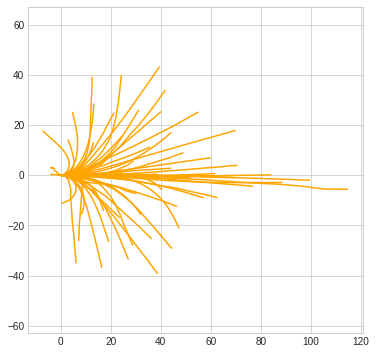

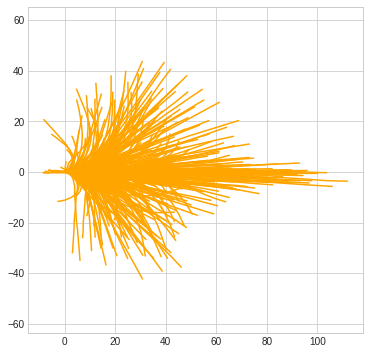

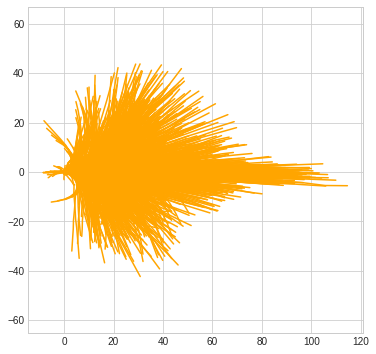

In [35]:
import pickle

def PlotGeneratedTrajectories(history, future_list):
  plt.figure(figsize=(6, 6))

  for future in future_list:
    plt.plot(future[:, 1], -future[:, 0], c='orange')

  # Keep aspect ratio of axis
  plt.axis('equal')
  plt.show()


# Epsilon is the amount of coverage in the set, 
# i.e. a real world trajectory is at most 8 meters from a trajectory in this set
# We released the set for epsilon = 2, 4, 8. Consult the paper for more information
# on how this set was created

PATH_TO_EPSILON_8_SET = "./drive/MyDrive/SDC_nuScenes_DS/prediction_trajectory_sets/epsilon_8.pkl"
PATH_TO_EPSILON_4_SET = "./drive/MyDrive/SDC_nuScenes_DS/prediction_trajectory_sets/epsilon_4.pkl"
PATH_TO_EPSILON_2_SET = "./drive/MyDrive/SDC_nuScenes_DS/prediction_trajectory_sets/epsilon_2.pkl"

trajectories_8 = pickle.load(open(PATH_TO_EPSILON_8_SET, 'rb'))
trajectories_8 = torch.Tensor(trajectories_8)
print(len(trajectories_8))

trajectories_4 = pickle.load(open(PATH_TO_EPSILON_4_SET, 'rb'))
trajectories_4 = torch.Tensor(trajectories_4)
print(len(trajectories_4))

trajectories_2 = pickle.load(open(PATH_TO_EPSILON_2_SET, 'rb'))
trajectories_2 = torch.Tensor(trajectories_2)
print(len(trajectories_2))

PlotGeneratedTrajectories(history_path, trajectories_8)
PlotGeneratedTrajectories(history_path, trajectories_4)
PlotGeneratedTrajectories(history_path, trajectories_2)

In [36]:
backbone = ResNetBackbone('resnet50')
features = backbone(image_tensor)

print(features.size())
features

torch.Size([1, 2048])


tensor([[0.9322, 0.9528, 1.0263,  ..., 0.9332, 0.9750, 0.9928]],
       grad_fn=<ViewBackward>)

In [ ]:
import torchvision.models as models

# Another backbone
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
features = resnext50_32x4d(image_tensor)

print(features.size())
features

In [37]:
backbone = ResNetBackbone('resnet50')
#backbone = models.resnext50_32x4d(pretrained=True)

covernet = CoverNet(backbone, num_modes=64)

# CoverNet outputs a probability distribution over the trajectory set.
# These are the logits of the probabilities
logits = covernet(image_tensor, agent_state_vector)

print(logits)
print(f"Length: {len(logits[0])}")

tensor([[ 0.4476,  0.0851, -0.5255,  0.1286,  0.1718, -0.1343, -0.0786,  0.1162,
          0.1420,  0.1773, -0.1709, -0.7937,  0.4433,  0.3008,  0.4981, -0.4823,
          0.4303,  0.2305, -0.2843, -0.1732, -0.1850,  0.1402,  0.2730, -0.1589,
         -0.2976,  0.6226,  0.3458, -0.1141,  0.1906,  0.5433, -0.0300,  0.2886,
         -0.0326,  0.2477, -0.0495,  0.5863,  0.1589,  0.2160,  0.4643, -0.2141,
          0.1238,  0.0448, -0.2489,  0.4622,  0.3626, -0.4740,  0.0518,  0.1080,
         -0.0936, -0.0096, -0.6122, -0.2732, -0.3881,  0.0325, -0.3022,  0.1432,
         -0.1034, -0.3233, -0.8036, -0.1831, -0.0053,  0.1343, -0.2574, -0.1582]],
       grad_fn=<AddmmBackward>)
Length: 64


In [39]:
print(f"trajectories size: {trajectories_8.size()} \n")
print(f"logits size: {logits.size()} \n")

sorted_logits_indexes = logits.argsort(descending=True)
print(f"Logits indeces: \n{sorted_logits_indexes}\n")

# Sort all 64 trajectory by logits
sorted_trajectories = trajectories_8[sorted_logits_indexes][0]
print(f"Sorted trajectories size: \n{sorted_trajectories.size()}")

trajectories size: torch.Size([64, 12, 2]) 

logits size: torch.Size([1, 64]) 

Logits indeces: 
tensor([[25, 35, 29, 14, 38, 43,  0, 12, 16, 44, 26, 13, 31, 22, 33, 17, 37, 28,
          9,  4, 36, 55,  8, 21, 61,  3, 40,  7, 47,  1, 46, 41, 53, 60, 49, 30,
         32, 34,  6, 48, 56, 27,  5, 63, 23, 10, 19, 59, 20, 39, 42, 62, 51, 18,
         24, 54, 57, 52, 45, 15,  2, 50, 11, 58]])

Sorted trajectories size: 
torch.Size([64, 12, 2])


Best 1; Probability: 0.6226121783256531


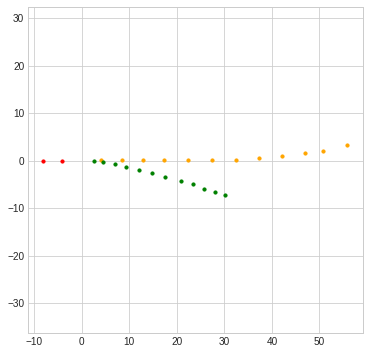

Best 2; Probability: 0.5863029956817627


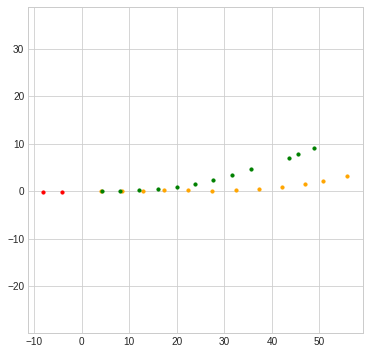

Best 3; Probability: 0.5432866215705872


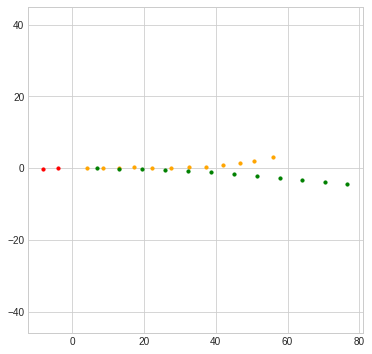

In [41]:
# Plot top N best trajectories

for i in range(3):
  print(f"Best {i + 1}; Probability: {logits[0][sorted_logits_indexes[0][i]]}")
  PlotPathWithPrediction(local_history_path, local_future_path, sorted_trajectories[i])

### Physics predictions

In [42]:
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

cv_model = ConstantVelocityHeading(sec_from_now=6, helper=helper)
physics_oracle = PhysicsOracle(sec_from_now=6, helper=helper)

### Predictions by Constant velocity heading

In [43]:
prediction_cv = cv_model(f"{instance_token_img}_{sample_token_img}").prediction[0]

print(f"Shape: [{len(prediction_cv)}, {len(prediction_cv[0])}]")

print(prediction_cv)

Shape: [12, 2]
[[ 651.65484689 1612.48251884]
 [ 648.61969378 1615.21103767]
 [ 645.58454068 1617.93955651]
 [ 642.54938757 1620.66807534]
 [ 639.51423446 1623.39659418]
 [ 636.47908135 1626.12511302]
 [ 633.44392825 1628.85363185]
 [ 630.40877514 1631.58215069]
 [ 627.37362203 1634.31066952]
 [ 624.33846892 1637.03918836]
 [ 621.30331581 1639.7677072 ]
 [ 618.26816271 1642.49622603]]


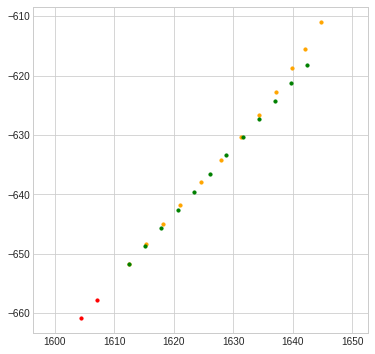

In [44]:
PlotPathWithPrediction(history_path, future_path, prediction_cv)

### Predictions by PhysicsOracle

In [45]:
prd_oracle = physics_oracle(f"{instance_token_img}_{sample_token_img}")
predictions_oracle = prd_oracle.prediction[0]
predictions_oracle

array([[ 651.65284726, 1612.48431645],
       [ 648.61169526, 1615.21822812],
       [ 645.566544  , 1617.95573502],
       [ 642.51739348, 1620.69683714],
       [ 639.4642437 , 1623.44153449],
       [ 636.40709466, 1626.18982707],
       [ 633.34594635, 1628.94171487],
       [ 630.28079879, 1631.69719789],
       [ 627.21165197, 1634.45627614],
       [ 624.13850588, 1637.21894961],
       [ 621.06136053, 1639.98521831],
       [ 617.98021592, 1642.75508224]])

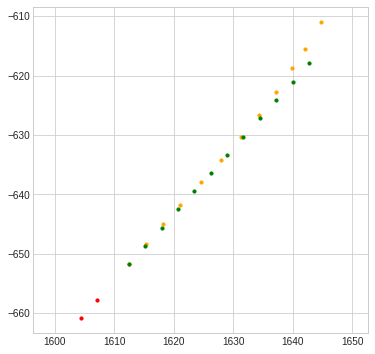

In [46]:
PlotPathWithPrediction(history_path, future_path, predictions_oracle)